In [1]:
cd ../..

/Users/fm/Desktop/Work/Patat


In [2]:
import importlib
import urllib
from collections import Counter
import pandas as pd

# Chargement et mise en forme corpus

In [3]:
# Parametres du notebook
#corpus_filename = 'data/corpus/220614-CorpusComplet.csv'
corpus_filename = 'data/corpus/220805-RecueilComplet.csv'
attr = 'site'
top_size = 300
threshold = 0.5

In [4]:
def load_corpus(corpus_filename):
    df_corpus = pd.read_csv(corpus_filename)
    # Suppression des articles qui n'ont pas été parsé de manière précise
    df_corpus = df_corpus[df_corpus['parse_method']=='parse']
    # Suppression articles vides éventuels
    df_corpus = df_corpus[df_corpus['article'].notna()]
    # Concaténation Titre et Article
    df_corpus.loc[:,'text'] = df_corpus['title']+'\n'+df_corpus['article']
    return df_corpus

In [5]:
df_corpus = load_corpus(corpus_filename)

In [6]:
df_corpus

,url_parsed,title,article,parse_method,date,tag,abstract,author,words,# site,...,propos rapporté,sources citées,titre décalé,degré infox,observateur,thème (abandonné),type infox (abandonné),Date de collection (abandonné),site,text
1,https://www.breizh-info.com/2022/02/23/180457/...,Tests – vaccins – pass : fabrique de la paniqu...,Cela fait 2 ans que la crise du coronavirus a ...,parse,Le \n\t\t\t\t\t\t\t\t\t\t23 février 2022,"['Santé', 'covid', 'crise', ""décoder l'éco"", '...",NaN,NaN,NaN,2,...,0.0,0.0,1.0,**,FB,vaccins,pseudo démonstration,mars 22,www.breizh-info.com,Tests – vaccins – pass : fabrique de la paniqu...
2,https://www.breizh-info.com/2022/02/20/180182/...,"Covid-19. La pandémie et les vaccins, pour mie...","Ces dernières semaines, le monde entier a prêt...",parse,Le \n\t\t\t\t\t\t\t\t\t\t20 février 2022,"['A La Une', 'Santé', ""coup d'etat mondial"", '...",NaN,NaN,NaN,2,...,1.0,0.0,0.0,**,FB,vaccins,complot,mars 22,www.breizh-info.com,"Covid-19. La pandémie et les vaccins, pour mie..."
3,https://www.breizh-info.com/2022/04/19/185260/...,Covid-19. Une épidémie quasiment terminée avan...,Voici mon avant dernier bulletin de situation ...,parse,Le \n\t\t\t\t\t\t\t\t\t\t19 avril 2022,"['A La Une', 'Santé', 'COVID-19', 'epidemie', ...",NaN,NaN,NaN,2,...,1.0,0.0,0.0,**,FB,vaccins,complot,mars 22,www.breizh-info.com,Covid-19. Une épidémie quasiment terminée avan...
4,https://www.breizh-info.com/2022/04/15/184984/...,"Piscine, voile, ramadan : scènes de la vie ord...",On a beaucoup parlé du Grand remplacement dura...,parse,Le \n\t\t\t\t\t\t\t\t\t\t15 avril 2022,"['Education', 'Société', 'burkini', 'hallal', ...",NaN,NaN,NaN,2,...,1.0,0.0,0.0,*,FB,grand remplacement,histoire inventée,21 avril 22,www.breizh-info.com,"Piscine, voile, ramadan : scènes de la vie ord..."
5,https://www.breizh-info.com/2021/11/02/173738/...,Faut-il vous métisser comme le suggère la pres...,Comme nous le verrons dans l’ensemble des étud...,parse,Le \n\t\t\t\t\t\t\t\t\t\t2 novembre 2021,"['Sciences', 'métis', 'metissage', 'race']",NaN,NaN,NaN,2,...,0.0,1.0,0.0,NaN,FB,racisme,pseudo science,21 avril 22,www.breizh-info.com,Faut-il vous métisser comme le suggère la pres...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,https://www.wikistrike.com/2022/07/pfizer-vien...,Pfizer vient d’être condamné à 75 millions dol...,Pfizer vient d’être condamné à une amende de 7...,parse,Publié par wikistrike.com\n ...,[],NaN,NaN,NaN,33,...,0.0,0.0,0.0,NaN,FB,NaN,NaN,NaN,www.wikistrike.com,Pfizer vient d’être condamné à 75 millions dol...
342,https://www.wikistrike.com/2022/07/l-italie-se...,L’Italie se révolte contre l’Union Européenne ...,"Après l’Espagne, la Grèce et le Portugal, l’It...",parse,Publié par wikistrike.com\n ...,[],NaN,NaN,NaN,33,...,0.0,0.0,0.0,NaN,FB,NaN,NaN,NaN,www.wikistrike.com,L’Italie se révolte contre l’Union Européenne ...
343,https://www.wikistrike.com/2022/07/variole-du-...,Variole du singe: Comme si les terriens étaien...,Alors qu’il n’y a pas de consensus au sein du ...,parse,Publié par wikistrike.com\n ...,[],NaN,NaN,NaN,33,...,0.0,0.0,0.0,*,FB,NaN,NaN,NaN,www.wikistrike.com,Variole du singe: Comme si les terriens étaien...
344,https://www.wikistrike.com/2022/07/un-sosie-de...,Un sosie de Poutine a-t-il été envoyé en Iran ?,"Un sosie de Biden, on le saurait tout de suite...",parse,Publié par wikistrike.com\n ...,[],NaN,NaN,NaN,33,...,0.0,0.0,0.0,*,FB,NaN,NaN,NaN,www.wikistrike.com,Un sosie de Poutine a-t-il été envoyé en Iran ...


# Compteurs de mots par valeur de l'attribut

In [7]:
import patat.ml.lex_analyser

In [8]:
importlib.reload(patat.ml.lex_analyser)
lex = patat.ml.lex_analyser.LexAnalyser()

In [12]:
def merge_texts(texts):
    result = ''
    for text in texts:
        result = result + text + '\n'
    return result

In [30]:
def merge_lemmas(texts):
    result = ''
    for text in texts:
        lemmas = lex.get_lemmas(lex.get_words(text))
        result = result + ' '.join(lemmas) + '\n'
    return result

In [13]:
def count_words_col(df_corpus,attr):
    df_texts = pd.pivot_table(df_corpus, values='text', index=None, columns=attr, aggfunc=merge_texts)
    wc = {}
    word_analysis = {}
    for key in df_texts.keys():
        text = df_texts[key]['text']
        count_colname = str(key)
        words = lex.get_words(text)
        lemmas = lex.get_lemmas(words)
#        wc[key] = lex.count_tokens(words)
        wc[key] = lex.count_tokens(lemmas)
        for word in wc[key]:
            word_dic = word_analysis.get(word,{})
            word_dic[count_colname]=wc[key][word]
            word_analysis[word]=word_dic
    return word_analysis

In [14]:
def get_df_counters(df_corpus,attr):
    word_count = count_words_col(df_corpus,attr)
    df_counters = pd.DataFrame(word_count).transpose()
    df_counters=df_counters.fillna(0)
    return df_counters

In [15]:
df_counters = get_df_counters(df_corpus,'infox')

In [16]:
df_counters

,0.0,1.0
renne,23.0,6.0
repriser,16.0,18.0
de,8439.0,18019.0
vol,21.0,10.0
commercial,18.0,24.0
...,...,...
regain,0.0,1.0
vivacité,0.0,1.0
click,0.0,1.0
plaît,0.0,1.0


# Identification des mots communs

In [17]:
threshold = 1

In [18]:
def get_commonwords(df_counters,top_size,threshold):
    # Tableau de listes des <top_size> mots les plus courants par catégorie
    top_words = {}
    for key in df_counters.keys():
        top_words[key] = list(df_counters.nlargest(top_size,key).index)
    # Unification des listes, avec multiples occurences
    merged_list = []
    for key in top_words.keys():
        merged_list = merged_list + top_words[key]
    # Comptage occurences et suppression
    counter = Counter(merged_list)
    occ_threshold = int(len(df_counters.keys())*threshold)
    commonwords = []
    for word in counter:
        occ = counter[word]
        if occ >= occ_threshold:
            commonwords.append(word)
    return commonwords

In [19]:
commonwords = get_commonwords(df_counters,top_size,threshold)
print(len(commonwords))

214


In [20]:
threshold

1

In [22]:
commonwords

['de',
 'la',
 'le',
 'un',
 'les',
 'et',
 'etre',
 'en',
 'devoir',
 'pour',
 'que',
 'au',
 'avoir',
 'dan',
 'qui',
 'il',
 'sur',
 'par',
 'pas',
 'plaire',
 'ce',
 'naitre',
 'faire',
 'pouvoir',
 'qu',
 'se',
 'avec',
 'ou',
 'son',
 'été',
 'cette',
 'leur',
 'nous',
 'mais',
 'on',
 'comme',
 'être',
 'pays',
 'aussi',
 'elle',
 'vous',
 'tout',
 'autre',
 'ces',
 'même',
 'voir',
 'politiquer',
 'monder',
 'si',
 'covid',
 'bien',
 'contrer',
 'nouveau',
 'sa',
 'ses',
 'sans',
 'partir',
 'entrer',
 'non',
 'ils',
 'france',
 'deux',
 'depuis',
 'aller',
 'an',
 'guerre',
 'je',
 'après',
 'grand',
 'otan',
 'russie',
 'dire',
 'ainsi',
 'tous',
 'personne',
 'ukraine',
 'selon',
 'président',
 'vaccin',
 'certain',
 'était',
 'permettre',
 'encore',
 'mettre',
 'où',
 'celer',
 'sou',
 'gouvernement',
 'prendre',
 'national',
 'mesurer',
 'premier',
 'ver',
 'sanitaire',
 'donc',
 'déclaré',
 'jour',
 'dernier',
 'cas',
 'russe',
 'vouloir',
 'très',
 'mondial',
 'moins',
 

In [23]:
pd.DataFrame(commonwords).to_csv('cw.csv')

In [24]:
df_counters

,0.0,1.0
renne,23.0,6.0
repriser,16.0,18.0
de,8439.0,18019.0
vol,21.0,10.0
commercial,18.0,24.0
...,...,...
regain,0.0,1.0
vivacité,0.0,1.0
click,0.0,1.0
plaît,0.0,1.0


# Wordclouds

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [31]:
df_texts = pd.pivot_table(df_corpus, values='text', index=None, columns=[attr], aggfunc=merge_lemmas)

In [32]:
df_texts

site,centrerusbranly.mid.ru,fr.sott.net,infodujour.fr,lemediaen442.fr,lesdeqodeurs.fr,lesmoutonsrebelles.com,lezarceleurs.blogspot.com,www.breizh-info.com,www.dreuz.info,www.francesoir.fr,www.lelibrepenseur.org,www.mondialisation.ca,www.polemia.com,www.profession-gendarme.com,www.voltairenet.org,www.wikistrike.com
text,message devoir cscor mesdames et messieurs che...,le pentagone organiser la victoire de ukraine ...,covid les vaccin naitre etre pas sans risquer ...,influenceur au million de vu nicolas scuderi d...,ces personne méritent le blâme pour la mourir ...,qu etre ce que le grand reset et que vouloir r...,les vaccin covid de pfizer détruisent tous les...,test vaccin pass fabriquer de la paniquer braq...,attentat crime tuerie et autre atrocités penda...,avortement sans condition jusqu neuf mois préc...,bill gater continuer de manipuler oms avec ses...,les destin tragique de star mondial comme céli...,la droit face impératif culturel facebook twit...,blackrock gater comment larry fink etre payé m...,ukraine bientôt dépecée par les alliés washing...,un grouper secret financé par soros travailler...


In [33]:
def display_wc(text,commonwords):
    wordcloud = WordCloud(background_color = 'white', stopwords = commonwords, max_words = 50, regexp=r"\w\w+").generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

Attribut : site
centrerusbranly.mid.ru


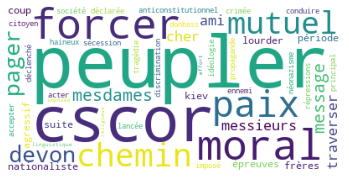

fr.sott.net


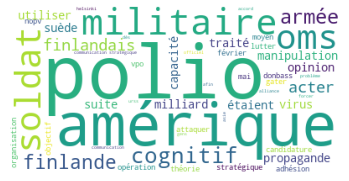

infodujour.fr


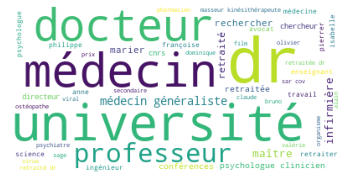

lemediaen442.fr


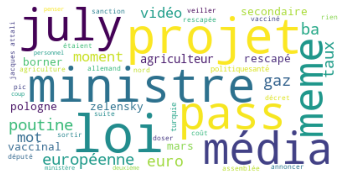

lesdeqodeurs.fr


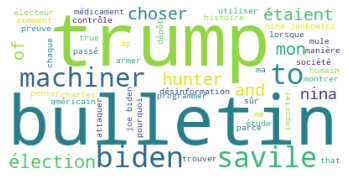

lesmoutonsrebelles.com


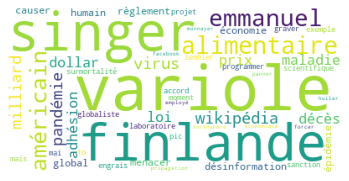

lezarceleurs.blogspot.com


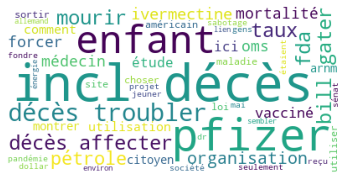

www.breizh-info.com


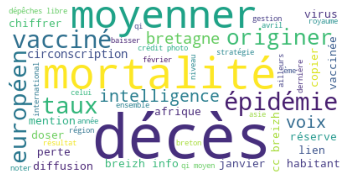

www.dreuz.info


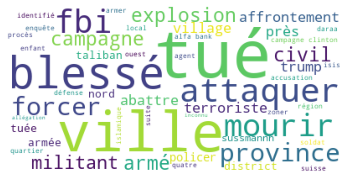

www.francesoir.fr


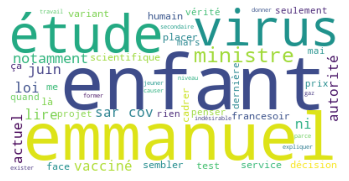

www.lelibrepenseur.org


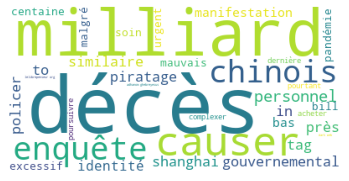

www.mondialisation.ca


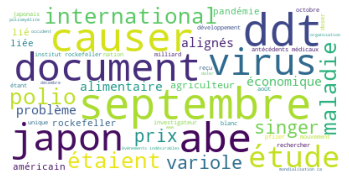

www.polemia.com


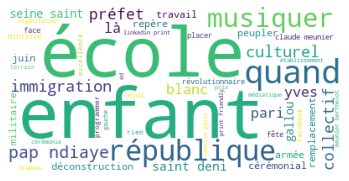

www.profession-gendarme.com


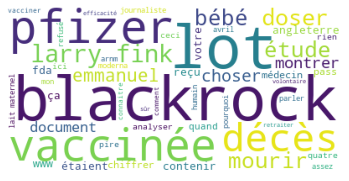

www.voltairenet.org


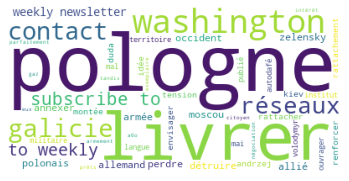

www.wikistrike.com


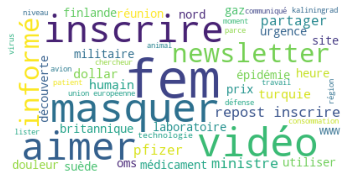

In [34]:
print(f'Attribut : {attr}')
for value in df_texts.keys():
    print(value)
    display_wc(df_texts[value][0],commonwords)

# Traitement d'une liste d'attributs

## Labels Booleens

In [ ]:
attrs = ['infox', 'signé',
    'lieux, dates et personnes ', 'lieux, dates et personnes cohérentes',
    'points de vue différents présentés', 'écriture de qualité',
    'faits', 'opinions', 'fausse nouvelle', 'insinuations',
    'exagération', 'scientifique sulfureux', 'des pages et des pages',
    'des chiffres et des tableaux', 'sophisme', 'inversion de la preuve',
    'invérifiable', 'propos rapporté', 'sources citées', 'titre décalé',]
top_size = 300
threshold = 1

In [ ]:
for attr in attrs:
    print('----------------------------------------------------')
    print(f'Label : {attr}')
    df_counters = get_df_counters(df_corpus,attr)
    commonwords = get_commonwords(df_counters,top_size,threshold)
    print(f'Common words : {commonwords}')
    print()
#    for value in df_counters.keys():
#        print(value)
#        print(df_counters.drop(index = stopwords).nlargest(30,value))

    df_texts = pd.pivot_table(df_corpus, values='text', index=None, columns=[attr], aggfunc=merge_texts)
    for value in df_texts.keys():
        print(f'{attr} = {value}')
        display_wc(df_texts[value][0],commonwords)

## Labels multivalués

In [ ]:
attrs = ['site']
top_size = 300
threshold = 0.5

In [ ]:
for attr in attrs:
    print('----------------------------------------------------')
    print(f'Label : {attr}')
    df_counters = get_df_counters(df_corpus,attr)
    commonwords = get_commonwords(df_counters,top_size,threshold)
    print(f'Common words : {commonwords}')
    print()
#    for value in df_counters.keys():
#        print(value)
#        print(df_counters.drop(index = stopwords).nlargest(30,value))

    df_texts = pd.pivot_table(df_corpus, values='text', index=None, columns=[attr], aggfunc=merge_texts)
    for value in df_texts.keys():
        print(value)
        display_wc(df_texts[value][0],commonwords)

# Bricolages

In [ ]:
keep_words = ['covid',
    'france',
    'politique',
    'guerre',
    'otan',
    'russie',
    'ukraine',
    'président',
    'gouvernement',
    'santé',
    'sanitaire',
    'macron',
    'europe',
    'vaccin',
    'russe',
    'sécurité',
    'vaccination',
    'twitter',
    'mondiale',
    'emmanuel',
    'chine',
    'politiques',
    'public',
    'femmes',
    'vaccins',
    'système',
    'population',
    'médias']
keep_words

In [ ]:
stop_words = []
for word in commonwords:
    if word not in keep_words:
        stop_words.append(word)

In [ ]:
stop_words

In [ ]:
df_texts = pd.pivot_table(df_corpus, values='text', index=None, columns=['infox'], aggfunc=merge_texts)

In [ ]:
df_texts

## Infox = 0

In [ ]:
text = df_texts[0]['text']
display_wc(text,stop_words)

## Infox = 1

In [ ]:
text = df_texts[1]['text']
display_wc(text,stop_words)

In [ ]:
df_counters = pd.DataFrame(count_words_col(df_corpus,'infox')).transpose()

In [ ]:
df_counters = df_counters.fillna(0)

In [ ]:
df_counters = df_counters.drop(axis = 0, index = stop_words)

In [ ]:
df_counters['freq_0'] = df_counters['0.0']/len(df_texts[0]['text'])*1000

In [ ]:
df_counters['freq_1'] = df_counters['1.0']/len(df_texts[1]['text'])*1000

In [ ]:
df_counters['freq_corpus'] = (df_counters['1.0']+df_counters['0.0'])/(len(df_texts[0]['text'])+len(df_texts[1]['text']))*1000

In [ ]:
df_counters.nlargest(50,'freq_corpus')

In [ ]:
df_counters['diff_freq']=(df_counters['freq_0']-df_counters['freq_1'])**2

In [ ]:
df_counters.nlargest(50,'diff_freq')

In [ ]:
df_counters.to_csv('data/analysis/220810-MotsInfox.csv',decimal=',')

In [36]:
# Bricolages

In [40]:
lex

In [42]:
def contains_word(text):
    words = lex.get_words(text)
    return 'al' in words

In [43]:
df_corpus[df_corpus['text'].apply(contains_word)]

,url_parsed,title,article,parse_method,date,tag,abstract,author,words,# site,...,propos rapporté,sources citées,titre décalé,degré infox,observateur,thème (abandonné),type infox (abandonné),Date de collection (abandonné),site,text
5,https://www.breizh-info.com/2021/11/02/173738/...,Faut-il vous métisser comme le suggère la pres...,Comme nous le verrons dans l’ensemble des étud...,parse,Le \n\t\t\t\t\t\t\t\t\t\t2 novembre 2021,"['Sciences', 'métis', 'metissage', 'race']",NaN,NaN,NaN,2,...,0.0,1.0,0.0,NaN,FB,racisme,pseudo science,21 avril 22,www.breizh-info.com,Faut-il vous métisser comme le suggère la pres...
6,https://www.breizh-info.com/2021/12/20/176485/...,"QI, races, différences, intelligence, délinqua...",Nous examinerons différentes théories pseudo-s...,parse,Le \n\t\t\t\t\t\t\t\t\t\t20 décembre 2021,"['Sciences', 'Intelligence', 'QI', 'race']",NaN,NaN,NaN,2,...,0.0,1.0,0.0,**,FB,racisme,pseudo science,21 avril 22,www.breizh-info.com,"QI, races, différences, intelligence, délinqua..."
7,https://www.breizh-info.com/2022/05/15/186521/...,Géopolitique. Une analyse pro-russe de la stra...,"Ci-dessous, et dans un esprit de refus d’une i...",parse,Le \n\t\t\t\t\t\t\t\t\t\t15 mai 2022,"['International', 'guerre', 'otan', 'russie', ...",NaN,NaN,NaN,2,...,0.0,0.0,0.0,**,FB,guerre,la voix de Moscou,NaN,www.breizh-info.com,Géopolitique. Une analyse pro-russe de la stra...
41,https://www.dreuz.info/2022/04/attentats-crime...,"Attentats, crimes, tueries et autres atrocités...",Dreuz publie chaque année depuis 9 ans la list...,parse,NaN,[],NaN,NaN,NaN,4,...,0.0,0.0,0.0,*,FB,islamisme,gloubi boulga,NaN,www.dreuz.info,"Attentats, crimes, tueries et autres atrocités..."
43,https://www.dreuz.info/2022/05/le-proces-du-fa...,Procès sur l’origine du dossier russe : le FBI...,Enquêteur spécial John Durham\nLe premier proc...,parse,NaN,[],NaN,NaN,NaN,4,...,0.0,1.0,0.0,*,FB,NaN,complot,NaN,www.dreuz.info,Procès sur l’origine du dossier russe : le FBI...
44,https://www.dreuz.info/2022/05/la-gauche-ameri...,La gauche américaine a tué 19 enfants et deux ...,"L’atroce tuerie perpétrée à Uvalde, Texas, voi...",parse,NaN,[],NaN,NaN,NaN,4,...,0.0,0.0,1.0,*,FB,armes,NaN,NaN,www.dreuz.info,La gauche américaine a tué 19 enfants et deux ...
181,https://lesdeqodeurs.fr/a-propos-de-ces-compte...,À propos de ces comptes Bot Twitter,Article original datant du 16/05/22Nous n’avon...,parse,17/05/2022,"['Bots', 'Elon Musk', 'New York Post', 'Twitter']",NaN,NaN,NaN,16,...,0.0,0.0,0.0,*,FB,complot,complot,NaN,lesdeqodeurs.fr,À propos de ces comptes Bot Twitter\nArticle o...
226,https://www.mondialisation.ca/colonialisme-ene...,Colonialisme énergétique\n\n\nPar Manlio Dinuc...,Visite d’État du président de la République it...,parse,"Mondialisation.ca, 09 juillet 2022",[],NaN,Par Manlio Dinucci,NaN,21,...,1.0,1.0,0.0,NaN,GP,NaN,NaN,NaN,www.mondialisation.ca,Colonialisme énergétique\n\n\nPar Manlio Dinuc...


In [54]:
text = df_corpus['text'][5]

In [55]:
'al' in lex.get_words(text)

True

In [56]:
for s in text.split('.'):
    if 'al' in lex.get_words(s):
        print(s)

 IQs of Native American-European Hybrids





Location


Age


Test


Europeans


Hybrids


Amerinds


Reference








N


IQ


N


IQ


N


IQ





1


Kansas


Adult


OTIS


–


100


536


93


179


67


Hunter & Sommermeir, 1922




2


South Dakota


10-15


OTIS


–


100


68


89


15


86


Fitzgerald & Ludeman, 1925




3


Mexico


7-10


SPM


155


98


571


94


194


83


Lynn et al
 Le caractère métissé entre les deux races a été confirmé par Cavali-Sforza et al
